<a href="https://colab.research.google.com/github/rikdantas/Algoritmos-Estruturas-Dados-II/blob/main/U3T1/source/U3T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U3T1
### Alunos: Emanoel Batista Pereira Filho, Ivamar Dantas Roque e Paulo Ricardo Dantas

**Escolher pontos turísticos de uma cidade e gerar a melhor rota entre eles**

In [ ]:
# Instalando as bibliotecas necessárias
# Mesma versão que foi usada no repositório referencia (requirements.txt)

!pip install OSMnx==1.0.1
!pip install geopandas==0.9.0
!pip install Shapely==1.8.4

In [2]:
# Importando bibliotecas

import logging
import time
import random
import numpy as np

from abc import abstractmethod
from typing import List, Callable, Tuple

import folium
from folium import DivIcon
from folium.plugins import MeasureControl

from networkx import shortest_path
import networkx as networkx

from osmnx import get_nearest_node, plot_graph_route
from osmnx import graph_from_place, config
import osmnx as osmnx

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

In [3]:
PLACES = {
    "Copacabana Palace": (-22.967154600081095, -43.17895302142972),
    "Pão de Açúcar": (-22.949110827078847, -43.1544314260103),
    "Cristo Redentor": (-22.951620238852218, -43.210629067069696),
    "Museu do Amanhã": (-22.89286439808468, -43.18092599883423),
    "Maracanã": (-22.911918960450024, -43.2301069838377),
    "Parque Lage": (-22.958025052092207, -43.21158925922644),
    "Escadaria Selarón": (-22.91524533910577, -43.179200921195786),
    "Real Gabinete Português": (-22.905103256171493, -43.182111557380146),
    "Forte de Copacabana": (-22.985736692386872, -43.18785809360464)
}


USE_SAVED_DISTANCES = True

START_PLACE = "Copacabana Palace"
END_PLACE = "Copacabana Palace"

In [4]:
m = folium.Map(PLACES[START_PLACE], zoom_start=14, control_scale=True)

for name, coordinates in PLACES.items():
    folium.Marker(coordinates, tooltip=name).add_to(m)
    folium.map.Marker(
        coordinates,
        icon=DivIcon(
            icon_size=(250, 36),
            icon_anchor=(0, 0),
            html='<div style="font-size: 15pt">' + name + '</div>',
        )
    ).add_to(m)
m.add_child(MeasureControl())
m.save("rj_places_on_map.html")
display(m)

## Funções

In [5]:
def calculate_distance_matrix(graph, coordinates):
    n = len(coordinates)
    distances_matrix = np.empty((n, n))

    for i in range(n):
        for j in range(n):
            source_node = osmnx.get_nearest_node(graph, coordinates[i])
            target_node = osmnx.get_nearest_node(graph, coordinates[j])
            distance = networkx.shortest_path_length(G=graph,
                                                     source=source_node,
                                                     target=target_node,
                                                     weight='length')
            distances_matrix[i][j] = distance / 1000

    return distances_matrix


def create_map(graph, path, route, place_names, coordinates, distances):
    route_map = osmnx.plot_route_folium(graph, path,
                                        tiles="OpenStreetMap",
                                        tooltip=f"Total distance {np.sum(distances):0.2f} km")

    for i in range(len(route) - 1):
        index = route[i]
        folium.Marker(coordinates[index],
                      tooltip=f"{i}: {place_names[index]}; {distances[i]:0.2f} km to next place").add_to(route_map)
        folium.map.Marker(
            coordinates[index],
            icon=DivIcon(
                icon_size=(250, 36),
                icon_anchor=(0, 0),
                html='<div style="font-size: 15pt">' + str(i) + '</div>',
            )
        ).add_to(route_map)
    return route_map


def calculate_full_path(graph, route, coordinates):
    full_path = []
    distances = []
    for i in range(0, len(route) - 1):
        from_index = route[i]
        end_index = route[i + 1]

        source_node = osmnx.get_nearest_node(graph, coordinates[from_index])
        target_node = osmnx.get_nearest_node(graph, coordinates[end_index])

        path = networkx.shortest_path(graph, source_node, target_node, weight='length')

        distance = networkx.shortest_path_length(G=graph, source=source_node, target=target_node,
                                                 weight='length') / 1000
        distances.append(distance)

        full_path += path[1:]

    return full_path, distances


def create_init_route(start, end, n):
    route = [k for k in range(n)]
    if start in route:
        route.remove(start)
    if end in route:
        route.remove(end)
    route = [start] + route + [end]
    return route

## Função de otimização

In [6]:
logger = logging.getLogger(__name__)


class SAModel:
    """
    Use case specific SA model that needs to be inherited by user of SARouteOptimizer.

    Contains methods used in SARouteOptimizer to
    - calculate cost for route
    - mutate route
    - calculate temperature
    - calculate probability from cost change and temperature
    """

    @abstractmethod
    def cost(self, route: List[int]) -> float:
        """
        Calculate cost for route.
        """
        raise NotImplementedError

    @staticmethod
    def schedule(t: int, max_temperature: float = 1.0, decay_constant: float = 0.005) -> float:
        """
        Calculate current temperature from iteration round t.
        """
        return max_temperature * np.exp(-decay_constant * t)

    @staticmethod
    def probability(delta_cost: float, temperature: float, k: float = 1) -> float:
        """
        Calculate acceptance probability for mutated route, based on cost change (vs. current solution) and temperature.
        """
        if delta_cost < 0:
            return 1
        else:
            return np.exp(-delta_cost / (k * temperature))

    def mutate(self, input_route: List[int], mutation_probability: float = 0.2) -> List[int]:
        """
        Mutate (modify) given route. This mutated route will be solution candidate that will be accepted or not, based
        on calculated probability.
        """
        route = input_route.copy()
        for k in range(len(route)):
            if random.random() < mutation_probability:
                self._swap(route)

        # Make sure that at least one change is made to input route
        if route == input_route:
            self._swap(route)

        return route

    def _swap(self, route):
        i, j = random.sample([k + 1 for k in range(len(route) - 2)], 2)
        value_i = route[i]
        value_j = route[j]
        route[i] = value_j
        route[j] = value_i


class SARouteOptimizer:
    """
    Simulated annealing route optimizer. With give model and termination criteria, finds optimal route that minimizes
    cost function defined by model.
    """

    def __init__(self,
                 model: SAModel,
                 max_iter: int = 10000,
                 max_iter_without_improvement: int = 2000,
                 min_temperature: float = 1e-12,
                 cost_threshold: float = -np.inf,
                 ):

        self.model = model
        self.max_iter = max_iter
        self.max_iter_without_improvement = max_iter_without_improvement
        self.min_temperature = min_temperature
        self.cost_threshold = cost_threshold

        self.temperatures = []
        self.costs = []
        self.probabilities = []
        self.delta_costs = []
        self.is_accepted = []

    def run(self, init_route: List[int]) -> Tuple[List[int], float]:
        """
        Find optimal route.

        :param init_route: Init guess for route.
        :return: optimal route, route cost
        """

        current_route = init_route.copy()
        best_route = current_route.copy()

        current_cost = self.model.cost(current_route)
        best_cost = self.model.cost(best_route)

        probability, delta_cost = 1, 0
        is_accepted = True
        no_improvement_counter = 0

        for t in range(self.max_iter):

            no_improvement_counter += 1
            temperature = self.model.schedule(t)

            if temperature < self.min_temperature:
                logger.info("Minimum temperature reached. Return solution")
                return best_route, best_cost

            self.temperatures.append(temperature)
            self.costs.append(current_cost)
            self.probabilities.append(probability)
            self.delta_costs.append(delta_cost)
            self.is_accepted.append(is_accepted)

            mutated_route = self.model.mutate(current_route.copy())
            mutated_route_cost = self.model.cost(mutated_route)
            logger.debug(f"Mutated route: {mutated_route}; cost {mutated_route_cost}")
            delta_cost = mutated_route_cost - current_cost

            is_accepted = False
            probability = self.model.probability(delta_cost, temperature)
            if probability >= random.uniform(0.0, 1.0):
                is_accepted = True
                current_route = mutated_route.copy()
                current_cost = mutated_route_cost
                if current_cost < best_cost:
                    best_route = current_route.copy()
                    best_cost = current_cost
                    logger.info(f"Found better solution; round {t}; cost {best_cost}")
                    no_improvement_counter = 0
                    if best_cost < self.cost_threshold:
                        logger.info("Cost reached required threshold value. Return solution.")
                        return best_route, best_cost

            logger.debug(f"Round {t}: temperature {temperature}; cost {current_cost}")

            if no_improvement_counter > self.max_iter_without_improvement:
                logger.info("Max iteration number without improvement reached. Return solution.")
                return best_route, best_cost

        logger.info("Max iteration number reached. Return solution.")
        return best_route, best_cost

    def plot_solution(self):
        plt.figure(1)

        ax1 = plt.subplot(1, 2, 1)

        color = 'tab:blue'
        ax1.plot(self.costs, color=color)
        ax1.set_ylabel('Cost', color=color)

        color = 'tab:red'
        ax2 = ax1.twinx()
        ax2.plot(self.temperatures, color=color)
        ax2.set_ylabel('Temperature', color=color)

        ax1.set_xlabel("Iteration")
        plt.title("Cost & temperature")

        plt.subplot(1, 2, 2)
        sc = plt.scatter(self.temperatures,
                         self.delta_costs,
                         c=np.array(self.probabilities) + 0.001,
                         norm=colors.LogNorm(),
                         edgecolors="k",
                         cmap=LinearSegmentedColormap.from_list("MyCmapName", ["b", "r"]))
        plt.colorbar(sc)
        plt.gca().invert_xaxis()
        plt.plot(np.array(self.temperatures)[self.is_accepted],
                 np.array(self.delta_costs)[self.is_accepted],
                 "kx",
                 markersize=3)

        plt.xlabel("Temperature")
        plt.ylabel("Cost change")
        plt.title("Probability")

        plt.tight_layout()
        plt.show()

Calculating graph


/usr/local/lib/python3.10/dist-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/usr/local/lib/python3.10/dist-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/usr/local/lib/python3.10/dist-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/usr/local/lib/python3.10/dist-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapel

Loading distances from file
Could not find rj_distances.txt file.
Calculating distances between points
Saving distances to file
Calculating optimal order of places
Solution took 10 ms


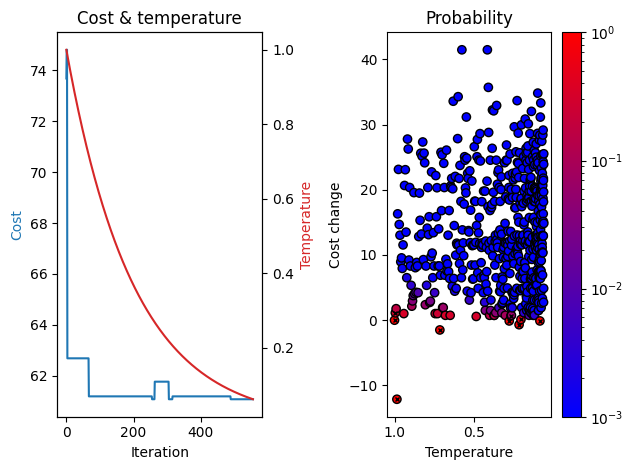

Creating optimal path
Creating map
Saving map to file


In [7]:
class Model(SAModel):

    def __init__(self, cost_matrix):
        self.cost_matrix = cost_matrix

    def cost(self, route):
        cost = 0
        for i in range(len(route) - 1):
            from_index = route[i]
            to_index = route[i + 1]
            cost += self.cost_matrix[from_index][to_index]
        return cost


config(log_console=False, use_cache=True, cache_folder='./cache')
logging.basicConfig(level=logging.INFO)

print("Calculating graph")
graph = graph_from_place('Rio de Janeiro, Brasil', network_type='drive')

place_names, coordinates = [], []
for name, coord in PLACES.items():
    place_names.append(name)
    coordinates.append(coord)

distances_matrix = None
if USE_SAVED_DISTANCES:
    print("Loading distances from file")
    try:
        distances_matrix = np.loadtxt("content/rj_distances.txt")
    except OSError:
        USE_SAVED_DISTANCES = False
        print("Could not find rj_distances.txt file.")

if not USE_SAVED_DISTANCES:
    print("Calculating distances between points")
    distances_matrix = calculate_distance_matrix(graph, coordinates)
    print("Saving distances to file")
    np.savetxt("rj_distances.txt", distances_matrix)

optimizer = SARouteOptimizer(model=Model(cost_matrix=distances_matrix),
                             max_iter=1000,
                             max_iter_without_improvement=300)

print("Calculating optimal order of places")
init_route = create_init_route(place_names.index(START_PLACE), place_names.index(END_PLACE), distances_matrix.shape[0])
start_time = time.time()
optimal_route, total_distance = optimizer.run(init_route)
end_time = time.time()
duration_ms = 1000 * (end_time - start_time)
print(f"Solution took {duration_ms:0.0f} ms")
optimizer.plot_solution()

print("Creating optimal path")
full_path, distances = calculate_full_path(graph, optimal_route, coordinates)

print("Creating map")
map = create_map(graph, full_path, optimal_route, place_names, coordinates, distances)

print("Saving map to file")
map.save('rj_optimal_route.html')